<a href="https://colab.research.google.com/github/Dimi-G/Capstone_Project/blob/main/Beginners_guide_to_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description
As part of our personalized diary assistant (link to complete project to follow soon) we need to identify emotions from text entries. The approach is that of an NLP-based multiclass classification task. Our training dataset is [dar-ai/emotion](https://huggingface.co/datasets/dair-ai/emotion). We introduce a K-Nearest Neighbors naive model and proceed with testing zero-shot classification and also implementing transfer learning from the [RoBERTa](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/roberta#transformers.RobertaForSequenceClassification) model by training a customed classification head and fine tuning the existing model with each default classification head.

This guide also shows how to save the models and push the final model in Hugging Face.

Special thanks to [bhadresh-savani](https://huggingface.co/bhadresh-savani/roberta-base-emotion), whose notebook was the main guide for this work but also to many others who have shared their work and contributed to better understanding this fascinating topic.

Comments, suggestions, and improvements are welcome. Please open an issue or a pull request.

## Imports

In [ ]:
#setting the gpu as first choice if it is accessible
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#mounting google drive for saving or loading the models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#huggingface and pytorch relevant installations
! pip install -U -q sentence-transformers
! pip install -q datasets
! pip install -U -q accelerate
! pip install -U -q transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have reques

In [ ]:
#installing joblib for saving the KNN model
!pip install joblib

In [ ]:
import pandas as pd
import numpy as np
import joblib
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer


## Naive Model

### Dataset import from Kaggle

The same emotions for NLP dataset is available in [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp). It can be downloaded and added to google drive to be accessed locally.

In [ ]:
train_df = pd.read_csv("drive/MyDrive/NLP_data/train.txt", delimiter=";", names=["text", "label"])
val_df = pd.read_csv("drive/MyDrive/NLP_data/val.txt", delimiter=";", names=["text", "label"])
test_df = pd.read_csv("drive/MyDrive/NLP_data/test.txt", delimiter=";", names=["text", "label"])

In [ ]:
# splitting datasets in half to reduce size
RANDOM_SEED =42
train_ds = train_df.sample(frac=0.5, random_state= RANDOM_SEED)
val_ds = val_df.sample(frac=0.5, random_state= RANDOM_SEED)
test_ds = test_df.sample(frac=0.5, random_state= RANDOM_SEED)

### Basic Exploratory Data Analysis

Checking the distribution of the labels

In [ ]:
train_ds['label'].value_counts()/train_ds.shape[0]

label
joy         0.334625
sadness     0.291625
anger       0.132500
fear        0.116500
love        0.088250
surprise    0.036500
Name: count, dtype: float64

In [ ]:
print(f"Training dataset: \n shape: {train_ds.shape} \n label counts:{train_ds['label'].value_counts()} \n label ratios: {train_ds['label'].value_counts()/train_ds.shape[0]}")
print(f"Training dataset: \n shape: {test_ds.shape} \n label counts:{test_ds['label'].value_counts()} \n label ratios: {test_ds['label'].value_counts()/test_ds.shape[0]}")
print(f"Training dataset: \n shape: {val_ds.shape} \n label counts:{val_ds['label'].value_counts()} \n label ratios: {val_ds['label'].value_counts()/val_ds.shape[0]}")

Training dataset: 
 shape: (8000, 2) 
 label counts:label
joy         2677
sadness     2333
anger       1060
fear         932
love         706
surprise     292
Name: count, dtype: int64 
 label ratios: label
joy         0.334625
sadness     0.291625
anger       0.132500
fear        0.116500
love        0.088250
surprise    0.036500
Name: count, dtype: float64
Training dataset: 
 shape: (1000, 2) 
 label counts:label
joy         344
sadness     291
anger       134
fear        112
love         87
surprise     32
Name: count, dtype: int64 
 label ratios: label
joy         0.344
sadness     0.291
anger       0.134
fear        0.112
love        0.087
surprise    0.032
Name: count, dtype: float64
Training dataset: 
 shape: (1000, 2) 
 label counts:label
joy         347
sadness     266
anger       131
fear        113
love        101
surprise     42
Name: count, dtype: int64 
 label ratios: label
joy         0.347
sadness     0.266
anger       0.131
fear        0.113
love        0.101
surprise

Dataset is split. Data is imbalanced but we have the same ratios per split.

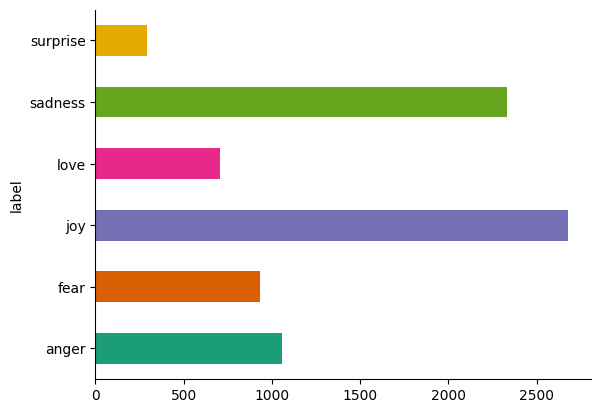

In [ ]:
train_ds.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Creating embeddings

Text embeddings are vectors (lists) or floating point numbers and they are designed to capture the semantic meaning and context of the words they represent. There are many models available which can be used for getting embeddings from given text. In this case we will use directly a [RoBERTa embedding Transformer](https://huggingface.co/sentence-transformers/all-roberta-large-v1). A more traditional approach would be employing CountVectorizer, TF-IDF, N-grams, Normalization, Stemming, Lemmatization, Stopwords, POS-tagging etc.

In [ ]:
embedder = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Input format has to be a list

In [ ]:
train_sentences = train_ds['text'].to_list()
test_sentences = test_ds['text'].to_list()
val_sentences = val_ds['text'].to_list()

In [ ]:
train_embeddings = embedder.encode(train_sentences)
test_embeddings = embedder.encode(test_sentences)
val_embeddings = embedder.encode(val_sentences)

In [ ]:
train_embeddings.shape

(8000, 1024)

Training dataset embeddings have 8000 data points, each represented by a 1024-dimensional vector

### KNN model and Hyperparameter tuning

Initialize KNeighborsClassifier and fit on training data

In [ ]:
model_baseline = KNeighborsClassifier()
model_baseline.fit(train_embeddings, train_ds['label'])

KNeighborsClassifier()

Scoring metric of choice is the F1-score, which is a harmonic mean of precision and recall. The F1-score is more sensitive to data distribution and is a suitable measure for classification problems on imbalanced datasets.


In [ ]:
cv_scores = cross_val_score(estimator=model_baseline, X=train_embeddings, y=train_ds['label'], scoring="f1_macro", cv=3)

print(
    f"""
      Baseline model CV scores by fold: {cv_scores},
      Mean CV score {cv_scores.mean()}
"""
)


      Baseline model CV scores by fold: [0.45456644 0.44547913 0.46004975],
      Mean CV score 0.45336510578372474



Running a Randomized Search CV on a set of hyperparameters for the KNN

In [ ]:
params = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15], # number of neighbors
    "weights": ["distance", "uniform"], # whether the votes from all neighbors should be counted equally or by distance to the prediction point
    "metric": ["cosine", "euclidean" ], # which metric to use for distance calculation
}

# define RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_distributions=params,
    n_iter=20,
    random_state=0,
    cv=3,
    scoring="f1_macro",
)

In [ ]:
random_search = clf.fit(train_embeddings, train_ds['label'])

In [ ]:
print(f"""
      Best parameters: {random_search.best_params_}
      F1-score: {random_search.best_score_}
""")


      Best parameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'cosine'}
      F1-score: 0.47207598712758814



Calling in the model with the best hyperparameters

In [ ]:
best_knn_model = random_search.best_estimator_
cv_scores_tuned = cross_val_score(estimator=best_knn_model, X=train_embeddings, y=train_ds['label'], scoring="f1_macro", cv=3)

print(
    f"""
      Best model CV scores by fold: {cv_scores_tuned},
      Mean CV scores: {cv_scores_tuned.mean()}
"""
)


      Best model CV scores by fold: [0.47280315 0.46260234 0.48082247],
      Mean CV scores: 0.47207598712758814



KNN with Hyperparameter tuning return marginally improved F1 score. We use the best estimator for prediction and print a classification report

### Performance Evaluation

In [ ]:
y_pred = best_knn_model.predict(test_embeddings)

In [ ]:
#converting y test to 1d array to match the y_pred for the classification report input
y_test = test_ds['label'].values

In [ ]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

       anger       0.60      0.49      0.53       134
        fear       0.56      0.46      0.50       112
         joy       0.67      0.69      0.68       344
        love       0.50      0.31      0.38        87
     sadness       0.59      0.76      0.66       291
    surprise       0.50      0.25      0.33        32

    accuracy                           0.61      1000
   macro avg       0.57      0.49      0.52      1000
weighted avg       0.60      0.61      0.60      1000



### Saving KNN model

In [ ]:
#saving the KNN best model
joblib_file = "knn_model.joblib"
joblib.dump(best_knn_model, joblib_file)

# Copy the model file to Google Drive
!cp knn_model.joblib /content/drive/MyDrive/NLP_data/knn_model.joblib

## Zero-shot classification

We test Zero-shot classification performance on our labels using the [facebook/bart-large-mnli](https://huggingface.co/facebook/bart-large-mnli) pipeline. It allows for text categorization without specific training on your labels. This pipeline takes your text and potential labels as input, predicting which labels apply based on the model's pre-existing knowledge. The results of the pipeline are for multilabel classification.


In [ ]:
zero_shot_classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Bringing data in the necessary format for the pipeline and saving in a list only the prevailing category prediction

In [ ]:
candidate_labels = list(train_ds['label'].unique())

In [ ]:
sequences = test_ds['text'].to_list()

In [ ]:
prediction = zero_shot_classifier(sequences, candidate_labels)

In [ ]:
#Choosing the label with the highest prediction score
pred_list = [prediction[i]['labels'][0] for i in range(0,len(prediction))]

In [ ]:
len(pred_list)

1000

### Performance Evaluation

In [ ]:
print(classification_report(y_test, pred_list ))

              precision    recall  f1-score   support

       anger       0.72      0.40      0.51       134
        fear       0.59      0.38      0.46       112
         joy       0.82      0.36      0.50       344
        love       0.44      0.23      0.30        87
     sadness       0.74      0.42      0.54       291
    surprise       0.05      0.84      0.10        32

    accuracy                           0.39      1000
   macro avg       0.56      0.44      0.40      1000
weighted avg       0.70      0.39      0.48      1000



The Bart zero shot classification does not perform better than the baseline KNN model. Especially the performance of the 'surprise' category is so poor that drops the macro accuracy.

## RoBERTa: A Robustly Optimized BERT Pretraining Approach

### Import dataset from Hugging Face
Using the same [emotion dataset](https://huggingface.co/datasets/dair-ai/emotion) but this time from the Hugginng Face interface.
Labels are sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [ ]:
from datasets import load_dataset
emotions = load_dataset("emotion")

The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Checking dataset format, tokenizing, downsizing

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# tokenize function
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched =True, batch_size =None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
#making a smaller dataset. since for the baseline models we used 50% of each split, we will use the same size and random seed too
RANDOM_SEED = 42
small_train_ds = emotions_encoded['train'].shuffle(seed=RANDOM_SEED).select(range(8000))
small_val_ds =  emotions_encoded['validation'].shuffle(seed=RANDOM_SEED).select(range(1000))
small_test_ds = emotions_encoded['test'].shuffle(seed=RANDOM_SEED).select(range(1000))

Prepare the datasets for use with PyTorch models

In [ ]:
small_train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
small_val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
small_test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### Create Metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## Train a RoBERTa custom classification head

We use the RobertaForSequenceClassification class, which is a transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output). The output is in logits, which is the non-normalized class prediction. The last step would be to utilize a softmax activation function for performing the multiclass classification. The default optimizer is [AdamW](https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html), while the cost function is Categorical Cross-Entropy (Softmax activation plus a Cross-Entropy loss)

In [ ]:
model_path = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The [default Roberta classification head](https://github.com/facebookresearch/fairseq/blob/a54021305d6b3c4c5959ac9395135f63202db8f1/fairseq/models/roberta/model.py#L394-L429) is consisted of a Linear Layer, a Dropout and then another Linear layer. We perform class inheritance and customize the classifier head by adding a ReLU activation function, another Dropout and another Linear at the end, where it's output is the number of our classes while at the same time reducing the dimentionality. The logic behing this is for trying to capture complex, non-linear relationships while at the same time addressing generalization.

In [ ]:
class CustomModel(AutoModelForSequenceClassification):
    def __init__(self, config):
        super(CustomModel, self).__init__(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 526),
            nn.Dropout(0.1),
            nn.Linear(526, 258),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(258, config.num_labels)
        )

    def forward(self, **inputs):
        outputs = self.roberta(**inputs)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output[:, 0, :].squeeze(1))
        return logits


Define the training hyperparameters and initialize the trainer

In [ ]:
cp_model = CustomModel.from_pretrained(model_path, num_labels=6)
cp_model.to(device)

batch_size = 64
logging_steps = len(small_train_ds) // batch_size

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    run_name="roberta_head_classification",
    disable_tqdm=False,
    logging_steps=logging_steps,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialize the trainer

In [ ]:
trainer = Trainer(
    model=cp_model,
    args=training_args,
    train_dataset=small_train_ds,
    eval_dataset=small_val_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
# Check which parameters require gradients (i.e., which parameters will be updated)
for name, param in cp_model.named_parameters():
    print(name, param.requires_grad)

roberta.embeddings.word_embeddings.weight True
roberta.embeddings.position_embeddings.weight True
roberta.embeddings.token_type_embeddings.weight True
roberta.embeddings.LayerNorm.weight True
roberta.embeddings.LayerNorm.bias True
roberta.encoder.layer.0.attention.self.query.weight True
roberta.encoder.layer.0.attention.self.query.bias True
roberta.encoder.layer.0.attention.self.key.weight True
roberta.encoder.layer.0.attention.self.key.bias True
roberta.encoder.layer.0.attention.self.value.weight True
roberta.encoder.layer.0.attention.self.value.bias True
roberta.encoder.layer.0.attention.output.dense.weight True
roberta.encoder.layer.0.attention.output.dense.bias True
roberta.encoder.layer.0.attention.output.LayerNorm.weight True
roberta.encoder.layer.0.attention.output.LayerNorm.bias True
roberta.encoder.layer.0.intermediate.dense.weight True
roberta.encoder.layer.0.intermediate.dense.bias True
roberta.encoder.layer.0.output.dense.weight True
roberta.encoder.layer.0.output.dense.bia

Above we see which layers will update their weights during training. It is not only the classification head that gets trained but the layers of the whole model (the base model that we use has 12 layers)

Train the model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.062200,0.461575,0.854000,0.852289
2,0.375500,0.260709,0.911000,0.911932
3,0.223600,0.231728,0.916000,0.916514
4,0.160700,0.213704,0.927000,0.926977
5,0.139100,0.198461,0.928000,0.928271
6,0.102500,0.216213,0.930000,0.928166
7,0.094300,0.198210,0.930000,0.930571
8,0.078000,0.199695,0.927000,0.926941


TrainOutput(global_step=1000, training_loss=0.2794912757873535, metrics={'train_runtime': 463.9938, 'train_samples_per_second': 137.933, 'train_steps_per_second': 2.155, 'total_flos': 2894325553152000.0, 'train_loss': 0.2794912757873535, 'epoch': 8.0})

Evaluate the model on the evaluation dataset

In [ ]:
results = trainer.evaluate()

Use it for predictions in the test dataset

In [ ]:
predictions = trainer.predict(small_test_ds)

In [ ]:
predictions.metrics

{'test_loss': 0.23923242092132568,
 'test_accuracy': 0.906,
 'test_f1': 0.9079521929029087,
 'test_runtime': 1.5536,
 'test_samples_per_second': 643.647,
 'test_steps_per_second': 10.298}

predictions.predictions contains the raw model outputs, which are typically probability distributions or logits for each class

In [ ]:
predictions.predictions

array([[ 6.2015705 , -1.3058568 , -1.5512701 , -1.0252806 , -0.93418014,
        -1.3763769 ],
       [-1.5035278 ,  6.412351  , -1.172498  , -1.344338  , -1.6135448 ,
        -1.098476  ],
       [-1.3084484 ,  6.4154224 , -0.201781  , -1.2430005 , -1.7253048 ,
        -1.9577422 ],
       ...,
       [-2.0018735 , -0.02654837,  5.5415163 , -1.8328933 , -1.6068403 ,
        -0.95545065],
       [-1.3723035 , -1.7863724 , -1.1501287 ,  5.525449  , -1.0601594 ,
        -0.7463257 ],
       [-1.6240891 , -1.9383676 , -1.6072104 ,  5.791693  , -0.0549685 ,
        -0.88809055]], dtype=float32)

The predicted label is the one with the maximum value along each row :

In [ ]:
y_preds = np.argmax(predictions.predictions, axis=1)

In [ ]:
print(classification_report(small_test_ds['label'].numpy(),y_preds ))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       287
           1       0.96      0.90      0.93       359
           2       0.74      0.88      0.80        73
           3       0.94      0.88      0.91       137
           4       0.91      0.80      0.85       115
           5       0.57      0.86      0.68        29

    accuracy                           0.91      1000
   macro avg       0.84      0.88      0.85      1000
weighted avg       0.91      0.91      0.91      1000



Save the model

In [ ]:
# model.save_pretrained('./model/custom_head')
# tokenizer.save_pretrained('./model/custom_head')

In [ ]:
# !cp -r './model/custom_head' /content/drive/MyDrive/NLP_data/model/custom_head

## Fine-tune RoBERTa on our dataset

The other approach is to  simply fine tune the RobertaForSequenceClassification on our dataset, by following the previous steps but not customizing the head.

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels = 6).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Info from HuggingFace](https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt): We get a warning after instantiating this pretrained model. This is because RoBERTa has not been pretrained on classifying pairs of sentences, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead. The warnings indicate that some weights were not used (the ones corresponding to the dropped pretraining head) and that some others were randomly initialized (the ones for the new head). It concludes by encouraging you to train the model, which is exactly what we are going to do now.

In [ ]:
batch_size = 64
logging_steps = len(small_train_ds) // batch_size

training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=10,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  warmup_steps=500,
                                  metric_for_best_model="f1",
                                  weight_decay=0.03,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  run_name = "roberta_classification",
                                  disable_tqdm=False)

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=small_train_ds,
                  eval_dataset=small_val_ds)

As with the previous model, we see that all layers will update their parameters during training

In [ ]:
# Check which parameters require gradients (i.e., which parameters will be updated)
for name, param in model.named_parameters():
    print(name, param.requires_grad)

roberta.embeddings.word_embeddings.weight True
roberta.embeddings.position_embeddings.weight True
roberta.embeddings.token_type_embeddings.weight True
roberta.embeddings.LayerNorm.weight True
roberta.embeddings.LayerNorm.bias True
roberta.encoder.layer.0.attention.self.query.weight True
roberta.encoder.layer.0.attention.self.query.bias True
roberta.encoder.layer.0.attention.self.key.weight True
roberta.encoder.layer.0.attention.self.key.bias True
roberta.encoder.layer.0.attention.self.value.weight True
roberta.encoder.layer.0.attention.self.value.bias True
roberta.encoder.layer.0.attention.output.dense.weight True
roberta.encoder.layer.0.attention.output.dense.bias True
roberta.encoder.layer.0.attention.output.LayerNorm.weight True
roberta.encoder.layer.0.attention.output.LayerNorm.bias True
roberta.encoder.layer.0.intermediate.dense.weight True
roberta.encoder.layer.0.intermediate.dense.bias True
roberta.encoder.layer.0.output.dense.weight True
roberta.encoder.layer.0.output.dense.bia

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.905809,0.696000,0.635424
2,No log,0.333750,0.892000,0.894442
3,No log,0.235102,0.924000,0.923688
4,0.664000,0.233785,0.921000,0.921451
5,0.664000,0.222111,0.928000,0.928132
6,0.664000,0.250961,0.927000,0.924395
7,0.664000,0.208428,0.932000,0.931937
8,0.125200,0.240892,0.937000,0.937182
9,0.125200,0.219512,0.931000,0.930919
10,0.125200,0.265703,0.934000,0.934046


TrainOutput(global_step=1250, training_loss=0.3253774353027344, metrics={'train_runtime': 590.4983, 'train_samples_per_second': 135.479, 'train_steps_per_second': 2.117, 'total_flos': 3617906941440000.0, 'train_loss': 0.3253774353027344, 'epoch': 10.0})

In [ ]:
results = trainer.evaluate()
results

{'eval_loss': 0.2408922016620636,
 'eval_accuracy': 0.937,
 'eval_f1': 0.9371817961103509,
 'eval_runtime': 1.73,
 'eval_samples_per_second': 578.047,
 'eval_steps_per_second': 9.249,
 'epoch': 10.0}

In [ ]:
predictions = trainer.predict(small_test_ds)

In [ ]:
predictions.metrics

{'test_loss': 0.30443549156188965,
 'test_accuracy': 0.907,
 'test_f1': 0.9085712291356082,
 'test_runtime': 1.6017,
 'test_samples_per_second': 624.341,
 'test_steps_per_second': 9.989}

In [ ]:
y_preds = np.argmax(predictions.predictions, axis=1)

In [ ]:
print(classification_report(small_test_ds['label'].numpy(),y_preds ))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       287
           1       0.96      0.90      0.93       359
           2       0.75      0.86      0.80        73
           3       0.93      0.87      0.90       137
           4       0.88      0.85      0.87       115
           5       0.59      0.79      0.68        29

    accuracy                           0.91      1000
   macro avg       0.84      0.88      0.85      1000
weighted avg       0.91      0.91      0.91      1000



## Conclusions

Performance Analysis: Fine-tuned vs Custom Head RoBERTa

Both model variants exhibited high performance, with the fine-tuned RoBERTa showing a slight edge. The fine-tuned model achieved an accuracy of 0.94 and an F1 score of 0.939 on the evaluation dataset, while maintaining robust performance on the test dataset with an accuracy and F1 score of 0.919.

As anticipated, performance on minority classes was comparatively lower. This issue could potentially be mitigated through the application of data balancing techniques during training.

The transformer models significantly outperformed the KNN baseline, which achieved an accuracy of 0.61. This stark contrast underscores the power of deep neural networks and transfer learning, particularly when leveraging models like RoBERTa, which are pre-trained on extensive datasets and contain approximately 125 million parameters.

However, it is crucial to consider the energy costs associated with these sophisticated models. The choice between a highly refined approach and a simpler model should be guided by the specific requirements of the task at hand. Not all problems necessitate such complex solutions, and the trade-offs between performance gains and computational resources should be carefully evaluated.

In conclusion, while the transformer models demonstrate impressive capabilities, the selection of an appropriate model should always be contextualized within the specific needs and constraints of the project.

Save model

In [ ]:
model.save_pretrained('./model')
tokenizer.save_pretrained('./model')

In [ ]:
!cp -r './model' /content/drive/MyDrive/NLP_data/model/

### Load model
If needed you can load the model from the drive location you have it saved

In [ ]:
!cp -r /content/drive/MyDrive/NLP_data/model/ './model'

In [ ]:
model_path = "./model"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

### Push model to Hugging Face

Once it is uploaded, add the label mapping at the config.json
   ```
   "id2label": {
     "0": "Sadness",
     "1": "Joy",
    "2": "Love",
     "3": "Anger",
     "4": "Fear",
     "5": "Surprise"
   }
    ```

In [ ]:
!huggingface-cli login

In [ ]:
!git config --global credential.helper store

In [ ]:
!sudo apt-get install git-lfs

In [ ]:
# use your git credentials
!git config --global user.email ""
!git config --global user.name ""
!git config --global user.password ""

In [ ]:
model.push_to_hub("roberta-base-emotion")

In [ ]:
tokenizer.push_to_hub("roberta-base-emotion")

### Pipeline use demo

In [ ]:
classifier = pipeline(model="Dimi-G/roberta-base-emotion")

config.json:   0%|          | 0.00/987 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

In [ ]:
emotions=classifier('i feel very happy and excited since i learned so many things', top_k=None)

In [ ]:
emotions

[{'label': 'Joy', 'score': 0.9991986155509949},
 {'label': 'Love', 'score': 0.0003064649645239115},
 {'label': 'Sadness', 'score': 0.0001680034474702552},
 {'label': 'Anger', 'score': 0.00012623333896044642},
 {'label': 'Surprise', 'score': 0.00011396403715480119},
 {'label': 'Fear', 'score': 8.671794785186648e-05}]